2025.10.21  
之前决定专注于开源项目. 参加了vllm biweekly meeting, 看了很多issue, 也看了project board.  
现在先把这个适配openvla的issue处理一下.


- 之前是练习, 在fixed_precdict_action中发现了个严重的问题.可能是pytorch, transformers等版本不一致造成的.
- 现在严格用了openvla的transformers, tokenizer, timm版本.
- 之前没有用的时候, 生成的token都是一样的. 现在换了之后, 不一样了, 但是会报错mask. 修改了predict_action之后可以了.


In [1]:

from typing import Any, Optional
from pathlib import Path
from PIL import Image
from types import MethodType
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import types

from transformers import AutoModelForVision2Seq, AutoProcessor

device = "cuda"


def fixed_predict_action(
    self, input_ids: Optional[torch.LongTensor] = None, unnorm_key: Optional[str] = None, **kwargs
) -> np.ndarray:
    """Fixed version that updates attention_mask when adding token to input_ids."""
    # If the special empty token ('') does not already appear after the colon (':') token in the prompt
    # (after "OUT:" or "ASSISTANT:"), insert it to match the inputs seen at training time
    if not torch.all(input_ids[:, -1] == 29871):
        input_ids = torch.cat(
            (input_ids, torch.unsqueeze(torch.Tensor([29871]).long(), dim=0).to(input_ids.device)), dim=1
        )
        # Also update attention_mask if it's in kwargs
        if 'attention_mask' in kwargs and kwargs['attention_mask'] is not None:
            attention_mask = kwargs['attention_mask']
            # Append a 1 (attended) for the new token
            new_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=attention_mask.device)
            kwargs['attention_mask'] = torch.cat([attention_mask, new_mask], dim=1)
    
    # Run VLA inference
    generated_ids = self.generate(input_ids, max_new_tokens=self.get_action_dim(unnorm_key), **kwargs)
    
    # Extract predicted action tokens and translate into (normalized) continuous actions
    predicted_action_token_ids = generated_ids[0, -self.get_action_dim(unnorm_key) :].cpu().numpy()
    discretized_actions = self.vocab_size - predicted_action_token_ids
    discretized_actions = np.clip(discretized_actions - 1, a_min=0, a_max=self.bin_centers.shape[0] - 1)
    normalized_actions = self.bin_centers[discretized_actions]
    
    # Unnormalize actions
    action_norm_stats = self.get_action_stats(unnorm_key)
    mask = action_norm_stats.get("mask", np.ones_like(action_norm_stats["q01"], dtype=bool))
    action_high, action_low = np.array(action_norm_stats["q99"]), np.array(action_norm_stats["q01"])
    actions = np.where(
        mask,
        0.5 * (normalized_actions + 1) * (action_high - action_low) + action_low,
        normalized_actions,
    )
    return actions, generated_ids


In [2]:
# Configuration
hf_model_name = "openvla/openvla-7b"
image_folder = "/home/yq/ssd/vllm-dir/vllm/yq/wip/pnp-soft-toys-traj6/images0"
image_paths = [p for p in Path(image_folder).iterdir()]
print(f"found {len(image_paths)} images in the folder")

instruction = "pick the toy bear"
prompt: str = f"In: What action should the robot take to {instruction}?\nOut:"

processor = AutoProcessor.from_pretrained(hf_model_name, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    hf_model_name,
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
).to(device)


# Patch the method
vla.predict_action = types.MethodType(fixed_predict_action, vla)
print("Fixed predict_action method to update attention_mask when adding token")


found 50 images in the folder


/home/yq/dev/miniconda/envs/vllm/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/yq/dev/miniconda/envs/vllm/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/yq/dev/miniconda/envs/vllm/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fixed predict_action method to update attention_mask when adding token


In [ ]:

## Generate
hf_generated_ids = []
for image_path in image_paths:
    image = Image.open(image_path).convert("RGB")
    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt",
    ).to(device, dtype=torch.bfloat16)
    #todo assert
    #todo check the unnorm_key of the scene
    #todo check temperature
    # predict_action default generate 7 tokens
    action, generated_ids = vla.predict_action(
        **inputs,
        unnorm_key='bridge_orig',
        do_sample=False
    )
    hf_generated_ids.append(generated_ids.cpu().numpy())

Saved results to result_hf.json


In [9]:
## Result
import json
with open("result_hf.json", "w") as f:
    json.dump([ids[0].tolist()[-7:] for ids in hf_generated_ids], f)
print(f"Saved results to result_hf.json")

Saved results to result_hf.json


In [4]:
# Load processor and VLA
hf_model_name = "openvla/openvla-7b"
# model_path = "/home/yq/ssd/vllm-dir/vllm/yq/openvla-7b"
model_path = hf_model_name
processor = AutoProcessor.from_pretrained(
    model_path, trust_remote_code=True)
vla_model = AutoModelForVision2Seq.from_pretrained(
    model_path,
    attn_implementation="eager", # [Optional] Requires flash attention
    torch_dtype=torch.bfloat16,
    # low_cpu_mem_usage=True,
    trust_remote_code=True
).to("cuda")


/home/yq/dev/miniconda/envs/vllm/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# Fix for predict_action: update attention_mask when adding token to input_ids
from typing import Optional
import numpy as np

original_predict_action = vla_model.predict_action

def fixed_predict_action(
    self, input_ids: Optional[torch.LongTensor] = None, unnorm_key: Optional[str] = None, **kwargs
) -> np.ndarray:
    """Fixed version that updates attention_mask when adding token to input_ids."""
    # If the special empty token ('') does not already appear after the colon (':') token in the prompt
    # (after "OUT:" or "ASSISTANT:"), insert it to match the inputs seen at training time
    if not torch.all(input_ids[:, -1] == 29871):
        input_ids = torch.cat(
            (input_ids, torch.unsqueeze(torch.Tensor([29871]).long(), dim=0).to(input_ids.device)), dim=1
        )
        # Also update attention_mask if it's in kwargs
        if 'attention_mask' in kwargs and kwargs['attention_mask'] is not None:
            attention_mask = kwargs['attention_mask']
            # Append a 1 (attended) for the new token
            new_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=attention_mask.device)
            kwargs['attention_mask'] = torch.cat([attention_mask, new_mask], dim=1)
    
    # Run VLA inference
    generated_ids = self.generate(input_ids, max_new_tokens=self.get_action_dim(unnorm_key), **kwargs)
    
    print(f"{generated_ids}")
    
    # Extract predicted action tokens and translate into (normalized) continuous actions
    predicted_action_token_ids = generated_ids[0, -self.get_action_dim(unnorm_key) :].cpu().numpy()
    discretized_actions = self.vocab_size - predicted_action_token_ids
    discretized_actions = np.clip(discretized_actions - 1, a_min=0, a_max=self.bin_centers.shape[0] - 1)
    normalized_actions = self.bin_centers[discretized_actions]
    
    # Unnormalize actions
    action_norm_stats = self.get_action_stats(unnorm_key)
    mask = action_norm_stats.get("mask", np.ones_like(action_norm_stats["q01"], dtype=bool))
    action_high, action_low = np.array(action_norm_stats["q99"]), np.array(action_norm_stats["q01"])
    actions = np.where(
        mask,
        0.5 * (normalized_actions + 1) * (action_high - action_low) + action_low,
        normalized_actions,
    )
    return actions

# Patch the method
import types
vla_model.predict_action = types.MethodType(fixed_predict_action, vla_model)
print("Fixed predict_action method to update attention_mask when adding token")


Fixed predict_action method to update attention_mask when adding token


image.size=(640, 480)
image.mode='RGB'
(95, 75, 74)


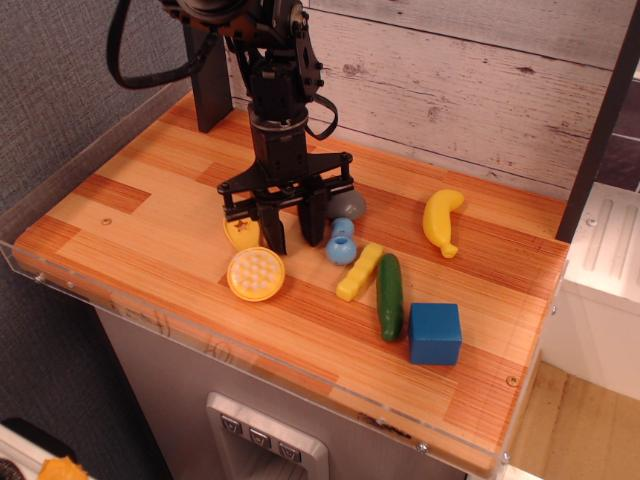

In [8]:
image: Image.Image = Image.open("pnp-rigid-objects-traj5/images0/im_10.jpg")
print(f'{image.size=}') # (640, 480)
print(f'{image.mode=}') # RGB
pixel = image.getpixel((0, 0))
print(pixel)  # (R, G, B)
# display the image
from IPython.display import display
display(image)


In [9]:
instruction: str = "move the end effector to the right"
prompt = f"In: What action should the robot take to {instruction}?\nOut:"


# Predict Action (7-DoF; un-normalize for BridgeV2)
inputs = processor(prompt, image).to("cuda:0", dtype=torch.bfloat16)
print(inputs.input_ids)
action = vla_model.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)




tensor([[    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
          4337,   278,  1095,  2779,   272,   304,   278,  1492, 29973,    13,
          3744, 29901]], device='cuda:0')
tensor([[    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
          4337,   278,  1095,  2779,   272,   304,   278,  1492, 29973,    13,
          3744, 29901, 29824, 31875, 31892, 31903, 31872, 31877, 31744,     2]],
       device='cuda:0')


In [ ]:
print(type(inputs)) # <class 'transformers.image_processing_base.BatchFeature'>
print(len(inputs)) # 3 tensors: input_ids, attention_mask, pixel_values
print(f'{inputs['input_ids'].shape=}')
print(f'{inputs['attention_mask'].shape=}')
print(f'{inputs['pixel_values'].shape=}')


print(type(action)) # <class 'numpy.ndarray'>
print(f'{action=}')

In [ ]:
print(f'{inputs['input_ids']=}')

In [ ]:
print(f'{inputs['attention_mask']=}')

In [ ]:
print(f'{inputs['pixel_values']=}')

In [ ]:
import pickle

with open("/home/yq/ssd/vllm-dir/vllm/yq/wip/pnp-many-objects-traj6/obs_dict.pkl", "rb") as f:
    obs = pickle.load(f)

with open("/home/yq/ssd/vllm-dir/vllm/yq/wip/pnp-many-objects-traj6/policy_out.pkl", "rb") as f:
    policy = pickle.load(f)



In [ ]:
for k, v in obs.items():
    print(k, v[0])


In [ ]:
print(policy[0])